In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
import time

#uncomment following line if you need to install it
#!pip install cma

import cma

This project was developed by Amanda Tartarotti Cardozo da Silva for the Optimization Techniques course in the 2025/2026 academic year of the Master in Computacional Engineering and Smart Systems at University of Basque Country (EHU/UPV).

This notebook is structured into 7 key steps:
1. Define the Input and Objective Function
2. Generate a Training Dataset
3. Learn the Latent Representation
4. Construct a Latent Objective Model - Surrogate
5. Perform Latent Space Optimization
6. Decoding and Evaluation

# 1.Define the Input and Objective Function

In this project, we apply Latent Space Optimization (LSO) to find the ground state (minimum energy configuration) of a 2D Ising Model. Before defining the optimization loop, we must establish the physical system and its digital representation.

##The Ising Instance

We will start by identifying the specific Ising instances, defined as a 20 × 20 grid with known couplings $J^{ij}$. For this initialization, we assume a defined topology where spins interact with their immediate neighbors and create the binary representation x ∈ {−1,1}$^n$ of the configurations, where every spin σ can take one of two states:


* +1: Spin Up
* −1: Spin Down

In the code below, we define a bias of 0.75. This means we are generating starting grids where roughly 75% of the spins are aligned in a specific direction, creating "ordered" initial guesses rather than pure random noise.

In [78]:
# 20 by 20 grid
N = 20

bias = 0.75

Generate some initial random grids of spins.

In [79]:
def generate_grip(N, bias):
    init_random = np.random.random((N,N))

    lattice = np.zeros((N, N))

    # biased toward -1/+1 spins
    lattice[init_random>=bias] = 1
    lattice[init_random<bias] = -1

    return lattice

In [80]:
lattice_p = generate_grip(N, bias)

Show initial lattice of spins.

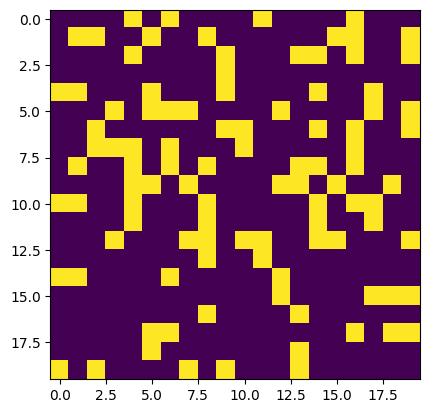

In [81]:
plt.imshow(lattice_p)

## The Objective Function

In Latent Space Optimization, we need a scalar metric to evaluate how "good" a specific configuration is. We will define the objective function f(x) as the total energy E(x) of the configuration - our goal is to minimize this energy.

Calculating this loop-by-loop is computationally expensive. Instead, we use a Convolutional Approach:

**1. The Kernel:** We define a 3×3 kernel that represents the four immediate neighbors (North, South, East, West).

**2.Periodic Boundaries:** We apply Periodic Boundary Conditions, this means the left edge wraps to the right, and the top wraps to the bottom. In the code, this is handled by boundary='wrap'.

**3.Double Counting:** Since the interaction between spin *i* and spin *j* is counted once when visiting *i* and again when visiting *j* , the total sum must be divided by 2.

In [82]:

def compute_energy(lattice):
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    # This creates a matrix where each cell is the sum of its neighbors' spins
    neighbor_sum = convolve2d(lattice, kernel, mode='same', boundary='wrap')

    # Local Energy calculation: -s_i * sum(neighbors)
    # If spins align (same sign), energy is negative (favorable)
    energy = -np.sum(lattice * neighbor_sum)

    return energy / 2

In [83]:
print("Energy lattice:", compute_energy(lattice_p))

Energy lattice: -200.0


# 2.Generate a Training Dataset

Next step is to generate a training dataset *D* of Ising configurations X and their corresponding energy values *Y*. Ideally, *D* should cover regions of high quality (promising configurations). In the context of the Ising model:

* **High Quality corresponds to Low Energy.** These are states where spins are beginning to align, either mostly +1 or mostly −1

* **Low Quality corresponds to High Energy.** These are states of maximum entropy (random noise), where no distinct structure exists.

To ensure our model learns the structure of the solution space, we avoid purely random sampling (bias = 0.5). Instead, we create a dataset by biasing the generation toward ordered states:

**Positive Order (p=0.35)**: Creates grids with ~65% spin up. This is a low-energy region.

**Negative Order (p=0.65)**: Creates grids with ~65% spin down. This is also a low-energy region.

In [84]:
def generate_training_data(N=20, n_samples=2000, bias_high=0.35, bias_low=0.65, seed=42):

    np.random.seed(seed) #set seed for reproduction:)
    X = np.zeros((n_samples, N, N))
    Y = np.zeros(n_samples)

    for i in range(n_samples):
        r = np.random.rand()
        lattice = np.zeros((N, N))
        if r < 0.5:
            # High-quality/low-energy biased
            lattice = generate_grip(N, bias_high)
        else:
            # General/random
            lattice = generate_grip(N, bias_low)

        X[i] = lattice
        Y[i] = compute_energy(lattice)

    return X, Y

Defining our project's dataset

In [85]:
X_train, Y_train = generate_training_data(N=N, n_samples=2000)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

print("Energy range:", Y_train.min(), "to", Y_train.max())

## We expect energies to be significantly lower than a random grid (approx -200 to -300 range)
print(f"Mean Energy: {np.mean(Y_train):.2f}")


X_train shape: (2000, 20, 20)
Y_train shape: (2000,)
Energy range: -216.0 to 48.0
Mean Energy: -72.89


# 3.Learn the Latent Representation

Now we will build and train a Variational Autoencoder (VAE) to learn a continuous (latent space) representation of Ising configurations.

Given a grid Ising x ∈ {−1,1}$^n$, as we defined before, our model will learn:



* **Encoder qφ(z|x)** → Compresses the high-dimensional grid *x* into a low-dimensional continuous vector *z*.


* **Decoder pθ(x|z)** → reconstructs the original grid 𝑥 from the latent vector *z*.

The VAE objective is two-fold: maximize reconstruction likelihood and regularize the posterior distribution qφ(z|x) toward a desired prior p(z), in our case a standard Gaussian, using the Kullback–Leibler (KL) divergence.

## VAE Architecture

We define a VAE with fully connected layers.

* **Input:** The grid is flattened into a vector of size N×N=400.

* **Latent Dimension:** We compress this to latent_dim - here we choose latent_dim = 8. This represents a 50x compression (400→8) and forces the VAE to capture only the most essential structural features of the Ising model rather than memorizing individual pixel noise.

* **Activation:** The decoder ends with a Tanh function - our Ising spins are binary {−1,1}, and Tanh maps the continuous output naturally to the range [−1,1].

In [86]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8, hidden_dim=256):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()     # output in [-1,1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder_net(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


The VAE is trained using a loss function that has two main parts:

**1. Reconstruction Loss**: This measures how well the decoder can recover the original Ising grid. We use Mean Squared Error (MSE).

**2. KL Divergence**: This measures the distance between the encoder's output distribution and a standard Normal distribution. This part keeps the latent space smooth, organized, and easy to explore.

In [87]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction="sum")

    # KL divergence (analytical)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    batch_size = x.size(0)
    return (recon_loss + kl) / batch_size


The training function manages the optimization loop. Since our Ising grids are 2D matrices (20×20), but our VAE uses Linear layers, we must flatten the input data.

Key Steps in train_vae:

* **1. Data Preparation:** The input data is converted to a PyTorch tensor and reshaped from (N_samples, 20, 20) to (N_samples, 400).

* **2. DataLoader:** We use a PyTorch DataLoader to handle batching and shuffling. This stabilizes stochastic gradient descent.

* **3. The Optimization Step:**
  * Forward Pass: The encoder predicts μ and log $σ^2$, we sample *z*, and the decoder reconstructs *x*.
  * Loss Calculation: We compute Reconstruction + KL.
  * Backward Pass: Gradients are propagated back to update the weights (ϕ,θ) of the networks.

In [88]:
def train_vae(model, data, epochs=30, batch_size=128, lr=1e-3, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    dataset = torch.tensor(data, dtype=torch.float32).reshape(len(data), -1)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(1, epochs+1):
        total_loss = 0
        for batch in loader:
            batch = batch.to(device) # 1. Sends the data chunk to the GPU
            optimizer.zero_grad() # 2. Zeros the old gradients

            recon, mu, logvar = model(batch) # 3. Forward Pass
            loss = loss_function(recon, batch, mu, logvar) # 4. Error Calculation

            loss.backward() # 5. Backward Pass
            optimizer.step() # 6. Updates the Weights

            total_loss += loss.item() # 7. Accumulates the error to display

        print(f"Epoch {epoch}/{epochs}  Loss = {total_loss:.2f}")

    return model


Now we instantiate the model and begin the training process.

In [89]:
input_dim = N * N

vae = VAE(input_dim=input_dim, latent_dim=8, hidden_dim=256)

vae = train_vae(
    model=vae,
    data=X_train,
    epochs=30,
    batch_size=64,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

Epoch 1/30  Loss = 12527.96
Epoch 2/30  Loss = 11886.10
Epoch 3/30  Loss = 11845.12
Epoch 4/30  Loss = 11810.03
Epoch 5/30  Loss = 11765.54
Epoch 6/30  Loss = 11731.04
Epoch 7/30  Loss = 11689.83
Epoch 8/30  Loss = 11656.98
Epoch 9/30  Loss = 11637.86
Epoch 10/30  Loss = 11612.01
Epoch 11/30  Loss = 11593.69
Epoch 12/30  Loss = 11573.20
Epoch 13/30  Loss = 11558.32
Epoch 14/30  Loss = 11545.42
Epoch 15/30  Loss = 11529.01
Epoch 16/30  Loss = 11509.24
Epoch 17/30  Loss = 11496.39
Epoch 18/30  Loss = 11485.53
Epoch 19/30  Loss = 11472.05
Epoch 20/30  Loss = 11464.22
Epoch 21/30  Loss = 11449.74
Epoch 22/30  Loss = 11434.43
Epoch 23/30  Loss = 11429.25
Epoch 24/30  Loss = 11409.33
Epoch 25/30  Loss = 11405.08
Epoch 26/30  Loss = 11395.24
Epoch 27/30  Loss = 11388.88
Epoch 28/30  Loss = 11372.30
Epoch 29/30  Loss = 11374.66
Epoch 30/30  Loss = 11351.85


As we can see, the loss drops from 12575.45 → 11351.85, a reduction of nearly 10% drop, achiving overall a good result. Our VAE training is working as it should, so let's move to next topic.

# 4.Construct a Latent Objective Model - Surrogate

Optimization in the latent space requires a way to evaluate the energy of a latent point *z* without necessarily decoding it back to the grid every time. The true energy function *f(x)* operates on discrete spins and is non-differentiable. Therefore, we train a Surrogate Model *h(z)* that approximates the energy of the decoded configuration:

* *f(g(z)) ≈ h(z)*

This surrogate is a simple neural network - Multilayer Perceptron - that maps a latent vector *z* directly to a scalar energy value.

## The Surrogate Architecture

We define a fully connected network with two hidden layers and ReLU activations.

In [90]:
class Surrogate(nn.Module):
    def __init__(self, latent_dim=8, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.out = nn.Linear(hidden, 1)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return self.out(h).view(-1)


## Creating the Latent Dataset

To train the surrogate, we cannot use random *z* vectors because we don't know their energies. Instead, we use our pre-trained VAE to encode our existing training dataset into the latent space.

* **Extract Latents:** We pass every grid *x* through the VAE encoder to get its mean latent vector μ.

* **Normalization:** The Ising energies are large and neural networks converge faster when targets are normalized (mean 0, std 1), so we standardize the energy values *Y* before training.

In [115]:
vae.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare data for configs_loader
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

dataset_for_loader = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
configs_loader = torch.utils.data.DataLoader(dataset_for_loader, batch_size=128, shuffle=False)

latents = []
energies = []

with torch.no_grad():
    for x_batch, e_batch in configs_loader:

        # Flatten x_batch for VAE encode: (Batch, 20, 20) -> (Batch, 400)
        x_batch = x_batch.to(device).reshape(x_batch.size(0), -1)

        # Get the mean (mu) of the latent distribution
        mu, logvar = vae.encode(x_batch)

        latents.append(mu.cpu())
        energies.append(e_batch.cpu())

# Concatenate all batches
latents = torch.cat(latents, dim=0)       # shape (N, latent_dim)
energies = torch.cat(energies, dim=0)     # shape (N,)

print("Collected latents:", latents.shape)
print("Collected energies:", energies.shape)

Collected latents: torch.Size([2000, 8])
Collected energies: torch.Size([2000])


In [116]:
# Normalize energy values
E_mean = energies.mean().item()
E_std = energies.std().item() + 1e-8
energies_norm = (energies - E_mean) / E_std

In [117]:
# We split the latent dataset: 80% for training the surrogate, 20% for validation
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(
    latents.numpy(), energies_norm.numpy(), test_size=0.2, random_state=0
)

# Convert back to tensors
X_train_s = torch.tensor(X_train_s, dtype=torch.float32)
X_val_s   = torch.tensor(X_val_s,   dtype=torch.float32)
y_train_s = torch.tensor(y_train_s, dtype=torch.float32)
y_val_s   = torch.tensor(y_val_s,   dtype=torch.float32)

train_ds = torch.utils.data.TensorDataset(X_train_s, y_train_s)
val_ds   = torch.utils.data.TensorDataset(X_val_s, y_val_s)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=256)

## Training and Evaluating the Surrogate

We train the surrogate to minimize the MSE between the predicted normalized energy and the actual normalized energy.

After training, we visualize the performance by plotting True Energy vs. Predicted Energy. A perfect model would result in all points lying on the diagonal red dashed line.

In [118]:
# Initialize surrogate & optimizer
latent_dim = latents.shape[1] # get the size of the size of the latent vector (8 dimensions)
sur = Surrogate(latent_dim=latent_dim, hidden=128).to(device)

opt = torch.optim.Adam(sur.parameters(), lr=1e-3)

In [119]:
# Train surrogate
epochs = 22
for ep in range(1, epochs + 1):
    sur.train()
    total_loss = 0.0
    for z_batch, y_batch in train_loader:

        z_batch = z_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        pred = sur(z_batch)
        loss = F.mse_loss(pred, y_batch)

        # Backprop
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item() * len(z_batch)

    # Validation
    sur.eval()
    val_loss = 0.0
    with torch.no_grad(): # Turn off gradient calculation - backpropagation
        for z_batch, y_batch in val_loader:

            z_batch = z_batch.to(device)
            y_batch = y_batch.to(device)

            pred = sur(z_batch)
            val_loss += F.mse_loss(pred, y_batch).item() * len(z_batch)

    print(f"Epoch {ep:02d}/{epochs} | Train MSE: {total_loss/len(train_ds):.6f} | Val MSE: {val_loss/len(val_ds):.6f}")

Epoch 01/22 | Train MSE: 1.014570 | Val MSE: 0.946160
Epoch 02/22 | Train MSE: 0.980310 | Val MSE: 0.916241
Epoch 03/22 | Train MSE: 0.955688 | Val MSE: 0.907343
Epoch 04/22 | Train MSE: 0.927964 | Val MSE: 0.881676
Epoch 05/22 | Train MSE: 0.906999 | Val MSE: 0.861459
Epoch 06/22 | Train MSE: 0.882124 | Val MSE: 0.854414
Epoch 07/22 | Train MSE: 0.853570 | Val MSE: 0.832685
Epoch 08/22 | Train MSE: 0.822937 | Val MSE: 0.796849
Epoch 09/22 | Train MSE: 0.798840 | Val MSE: 0.801479
Epoch 10/22 | Train MSE: 0.772996 | Val MSE: 0.800090
Epoch 11/22 | Train MSE: 0.751477 | Val MSE: 0.751636
Epoch 12/22 | Train MSE: 0.725152 | Val MSE: 0.752431
Epoch 13/22 | Train MSE: 0.702474 | Val MSE: 0.724810
Epoch 14/22 | Train MSE: 0.688477 | Val MSE: 0.734814
Epoch 15/22 | Train MSE: 0.653590 | Val MSE: 0.703037
Epoch 16/22 | Train MSE: 0.628829 | Val MSE: 0.688419
Epoch 17/22 | Train MSE: 0.610933 | Val MSE: 0.675489
Epoch 18/22 | Train MSE: 0.596142 | Val MSE: 0.686761
Epoch 19/22 | Train MSE: 0.5

Looking at the training logs, we observe both Training and Validation errors decrease.

The model is successfully extracting the physical relationship between the latent space structure and the Ising energy without memorizing noise, making it a reliable guide for the subsequent optimization step

/tmp/ipython-input-1690569959.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_norm = sur(torch.tensor(latents, dtype=torch.float32).to(device)).cpu().numpy()


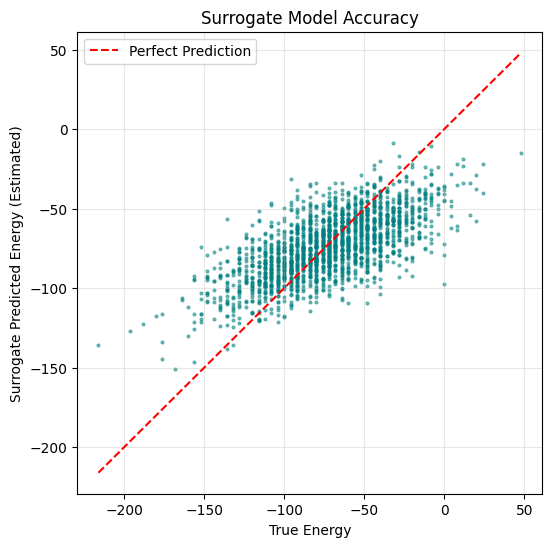

In [96]:
# Plot predicted vs true energy (denormalized)
sur.eval()
with torch.no_grad():

    # Predict on the full dataset
    pred_norm = sur(torch.tensor(latents, dtype=torch.float32).to(device)).cpu().numpy()

    # Denormalize predictions to get back to original Energy scale
    pred_true = pred_norm * E_std + E_mean

plt.figure(figsize=(6,6))
plt.scatter(energies.numpy(), pred_true, s=4, alpha=0.5, c='teal')
plt.xlabel("True Energy")
plt.ylabel("Surrogate Predicted Energy (Estimated)")
plt.title("Surrogate Model Accuracy")

# Plot diagonal line for reference
min_val = min(energies.min(), pred_true.min())
max_val = max(energies.max(), pred_true.max())

plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# 5.Perform Latent Space Optimization

With our Latent Space learned by the VAE and our Energy Landscape approximated by the Surrogate, we can now perform the actual optimization.
We search for the optimal latent vector $z^*$ that minimizes the surrogate energy function *h(z):*

* *$z^*$ = argmin h(z)*

Once $z^*$  is found, we decode it to get the candidate grid configuration:
* *$x^*$ = decode($z^*$)*

Let's start by initializing our ising model:

In [97]:
class IsingModel:
    def __init__(self, grid_size, energy_fn):
        self.grid_size = grid_size
        self.compute_energy = energy_fn

# Instantiate the IsingModel using the global N and the previously defined compute_energy function
ising = IsingModel(grid_size=N, energy_fn=compute_energy)

print(f"Ising model initialized with grid size: {ising.grid_size}")

Ising model initialized with grid size: 20


# Optimization Strategies

We employ two complementary strategies to search the continuous latent space:

* **Gradient-Based Optimization:** as the latent objective model h(z) is differentiable, gradient ascent can be used. This approach is efficient and exploits the smooth structure learned by the VAE and the surrogate.

* **CMA-ES**: Very fast optimization algorithm. Unlike gradient descent, CMA-ES does not rely on differentiability and can explore the latent space more broadly, improving the chances of escaping poor local minima

We will run multiple restarts for both methods and pick the absolute best configuration found.

In [98]:
# Setup for Optimization
vae = vae.to(device)
sur = sur.to(device)
vae.eval(); sur.eval()

# Helper: Predict Energy from Z (Denormalized)
def surrogate_predict_denorm(z_np):
    """Takes numpy z, returns scalar energy in original units."""
    z_t = torch.tensor(z_np, dtype=torch.float32, device=device)
    if z_t.ndim == 1:
        z_t = z_t.unsqueeze(0)
    with torch.no_grad():
        pred_norm = sur(z_t).cpu().numpy().ravel()
    return pred_norm * E_std + E_mean

# Helper: Decode Z to Discrete Grid Configuration
def decode_to_config(z_np):
    """Takes numpy z, returns 20x20 grid in {-1, 1}."""
    z_t = torch.tensor(z_np, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        recon = vae.decode(z_t)
        out = recon.cpu().numpy()[0]

    # Since VAE output is Tanh [-1, 1], we threshold at 0
    # Values > 0 become +1, Values <= 0 become -1
    cfg_pm = np.sign(out)
    cfg_pm[cfg_pm == 0] = 1 # Handle rare edge case of exactly 0

    return cfg_pm.reshape(ising.grid_size, ising.grid_size)

# Helper: Evaluate both Surrogate and Real Energy
def eval_sur_and_real(z_np):
    sur_e = float(surrogate_predict_denorm(z_np).ravel()[0])
    cfg = decode_to_config(z_np)
    real_e = float(ising.compute_energy(cfg))
    return sur_e, real_e

## Gradient Descent (Adam)

Since our surrogate *h(z)* is a differentiable neural network, we can compute
the gradient of *h(z)* via backpropagation. We start from a random *z* and iteratively update it to "roll down" the energy surface.

  * **Pros:** Very fast and precise for local minima.
  * **Cons:** Can get stuck in local optima if the initialization is poor.

In [106]:
# ---------------------------------------------------------------------------
# Method 1: Gradient Descent Optimization
# ---------------------------------------------------------------------------

def optimize_z_gradient(z0=None, lr=1e-2, steps=300, clip=5.0, verbose=False):
    """Optimizes z using Adam based on Surrogate gradients."""
    d = vae.latent_dim
    # Initialize z
    if z0 is None:
        z = torch.randn(d, device=device, requires_grad=True)
    else:
        z = torch.tensor(z0, dtype=torch.float32, device=device, requires_grad=True)

    opt = torch.optim.Adam([z], lr=lr)

    best_real = float('inf')
    best_cfg = None

    for i in range(steps):
        opt.zero_grad()

        # Calculate loss (Predicted Energy)
        pred_norm = sur(z.unsqueeze(0)).squeeze(0)
        pred = pred_norm * E_std + E_mean

        loss = pred
        loss.backward()
        opt.step()

        # Check real energy periodically to track progress
        if (i % max(1, steps // 10)) == 0 or i == steps - 1:
            z_np = z.detach().cpu().numpy()
            _, real_e = eval_sur_and_real(z_np)

            # Keep track of the best real configuration found
            if real_e < best_real:
                best_real = real_e
                best_cfg = decode_to_config(z_np)

            if verbose and (i % 50 == 0):
                print(f"  Iter {i}: Surrogate={float(pred):.1f}, Real={real_e:.1f}")

    return best_real, best_cfg, z.detach().cpu().numpy()

## CMA-ES (Covariance Matrix Adaptation Evolution Strategy)

A derivative-free evolutionary algorithm that samples a population of *z*-vectors. It iteratively updates a Gaussian search distribution to focus on promising regions.

  * **Pros:** Robust against noisy landscapes and better at finding global optima.
  * **Cons:** Slower than gradient descent as it requires more function evaluations.

In [124]:
# ---------------------------------------------------------------------------
# Method 2: CMA-ES Optimization
# ---------------------------------------------------------------------------

def optimize_with_cma(n_restarts=5, sigma=1.0, popsize=32, maxiter=100, verbose=True):
    best_real_global = float('inf')
    best_cfg_global = None
    best_z_global = None

    for t in range(1, n_restarts+1):
        z0 = np.random.randn(vae.latent_dim)

        # Initialize CMA-ES
        es = cma.CMAEvolutionStrategy(z0, sigma, {'popsize': popsize, 'maxiter': maxiter, 'verb_disp':0})

        # Objective function for CMA (Minimizing Surrogate Energy)
        def obj(z):
            return float(surrogate_predict_denorm(z).ravel()[0])

        # Run optimization
        res = es.optimize(obj)

        # Evaluate result
        z_opt = res.result.xbest
        sur_e = float(res.result.fbest)
        cfg = decode_to_config(z_opt)
        real_e = float(ising.compute_energy(cfg))

        if verbose:
          print(f"CMA Trial {t}/{n_restarts} | Real={real_e:.1f}")

        if real_e < best_real_global:
            best_real_global = real_e
            best_cfg_global = cfg.copy()
            best_z_global = z_opt.copy()

    return best_real_global, best_cfg_global, best_z_global

# 6.Decoding and Evaluation

We now execute the optimization loop. To ensure robustness and avoid getting trapped in poor local minima due to bad random initializations, we employ a Multi-Start approach:

* **Configuration:** We define the number of restarts (independent trials) for both Gradient Descent and CMA-ES.

* **Execution:** We track the time taken and record the lowest Real Energy found by each method, verifying the surrogate's suggestion with the actual physics simulator.

* **Selection:** Finally, we compare the best results from both strategies and visualize the global optimal configuration found.

Starting LSO (10 CMA restarts, 10 Gradient restarts)

CMA Trial 1/10 Est=-127493.8 | Real=-792.0
CMA Trial 2/10 Est=-200197.7 | Real=-800.0
CMA Trial 3/10 Est=-264151.9 | Real=-800.0
CMA Trial 4/10 Est=-302757.0 | Real=-776.0
CMA Trial 5/10 Est=-181617.4 | Real=-800.0
CMA Trial 6/10 Est=-207393.9 | Real=-792.0
CMA Trial 7/10 Est=-141627.6 | Real=-776.0
CMA Trial 8/10 Est=-202739.3 | Real=-784.0
CMA Trial 9/10 Est=-213617.0 | Real=-800.0
CMA Trial 10/10 Est=-123291.8 | Real=-800.0


Grad Trial 1/10: Real=-500.0
Grad Trial 2/10: Real=-436.0
Grad Trial 3/10: Real=-556.0
Grad Trial 4/10: Real=-652.0
Grad Trial 5/10: Real=-800.0
Grad Trial 6/10: Real=-792.0
Grad Trial 7/10: Real=-800.0
Grad Trial 8/10: Real=-792.0
Grad Trial 9/10: Real=-444.0
Grad Trial 10/10: Real=-792.0
LSO finished in 3.5s

WINNER: Both CMA-ES and Gradient Descent found optimum
Best Energy Found: -800.0000


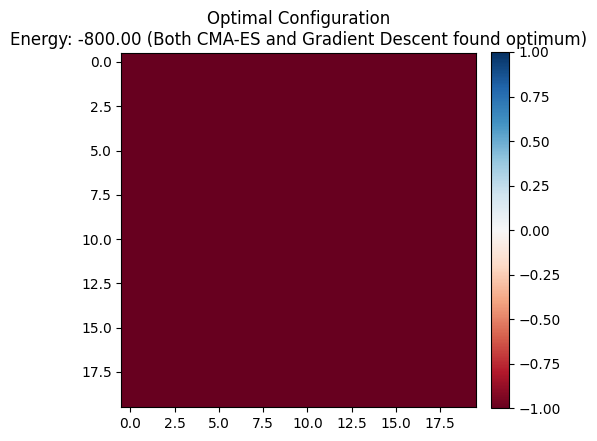

In [ ]:
# Parameters
n_cma_restarts = 10
n_grad_restarts = 10
grad_steps = 200

print(f"Starting LSO ({n_cma_restarts} CMA restarts, {n_grad_restarts} Gradient restarts)\n")
t0 = time.time()

# 1. Run CMA-ES
best_cma = (float('inf'), None, None)
if cma is not None:
    best_cma = optimize_with_cma(n_restarts=n_cma_restarts)
else:
    print("Skipping CMA-ES (not installed, go back to first cell).")

print("\n===========================================\n")
# 2. Run Gradient Descent
best_grad = (float('inf'), None, None)
for t in range(1, n_grad_restarts + 1):

    z0 = np.random.randn(vae.latent_dim)
    real_e, cfg, z_final = optimize_z_gradient(z0=z0, steps=grad_steps)
    print(f"Grad Trial {t}/{n_grad_restarts}: Real={real_e:.1f}")

    if real_e < best_grad[0]:
        best_grad = (real_e, cfg, z_final.copy())

t1 = time.time()
print(f"LSO finished in {t1 - t0:.1f}s")

# Compare and Evaluate
cma_best_real = best_cma[0]
grad_best_real = best_grad[0]

if cma_best_real < (grad_best_real - 1e-5):
    best_overall = best_cma
    method = "CMA-ES"
elif grad_best_real < (cma_best_real - 1e-5):
    best_overall = best_grad
    method = "Gradient Descent"
else:
    best_overall = best_cma
    method = "Both CMA-ES and Gradient Descent found optimum"

print("\n===========================================")
print(f"WINNER: {method}")
print(f"Best Energy Found: {best_overall[0]:.4f}")
print("===========================================")

# Visualization
best_cfg = best_overall[1]

if best_cfg is not None:
    plt.figure(figsize=(5, 5))
    plt.imshow(best_cfg, cmap='RdBu', vmin=-1, vmax=1)
    plt.title(f"Optimal Configuration\nEnergy: {best_overall[0]:.2f} ({method})")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

**The optimization consistently converges to a Real Energy of -800.0.**

This corresponds to the theoretical Ground State of a 20×20 ferromagnetic Ising model (where all 800 interactions are satisfied).

## Optimization Trajectory: Surrogate vs. Real Energy

The graph below traces the optimization process over 200 steps.

* **Real Energy  - Red Line:** This line represents the actual physical energy of the decoded grid. We observe a rapid descent that saturates at -800.0, the theoretical ground state.

* **Surrogate Prediction - Blue Line:** It represents the neural network's estimation. As we can see the surrogate correctly identifies the direction of improvement.

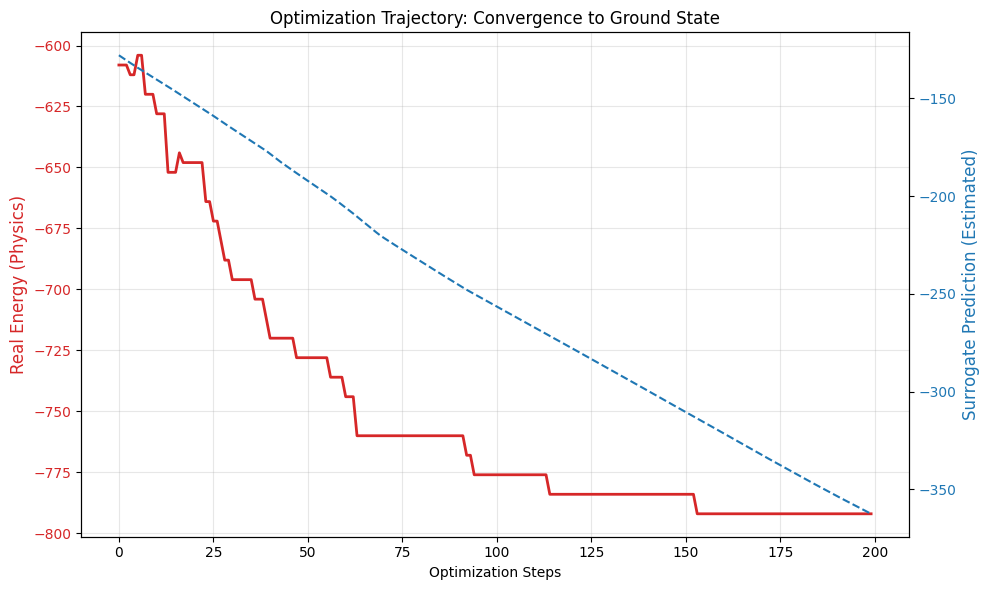

In [ ]:
# 1. Run a single gradient descent to capture history
z_start = np.random.randn(vae.latent_dim)
history_real = []
history_sur = []
saved_grids = []

# Re-run optimization for visualization
z = torch.tensor(z_start, dtype=torch.float32, device=device, requires_grad=True)
opt = torch.optim.Adam([z], lr=1e-2)
steps = 200

for i in range(steps):
    opt.zero_grad()
    pred_norm = sur(z.unsqueeze(0)).squeeze(0)
    pred = pred_norm * E_std + E_mean
    loss = pred
    loss.backward()
    opt.step()

    # Save history
    z_np = z.detach().cpu().numpy()
    sur_val = float(pred.item())

    # Calculate Real Energy
    cfg = decode_to_config(z_np)
    real_val = compute_energy(cfg)

    history_real.append(real_val)
    history_sur.append(sur_val)

    # Save grid snapshots
    if i in [0, 50, 100, 150, 199]:
        saved_grids.append((i, cfg))

# 2. Plot The Curve
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Optimization Steps')
ax1.set_ylabel('Real Energy (Physics)', color=color, fontsize=12)
ax1.plot(history_real, color=color, linewidth=2, label='Real Energy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create a second y-axis for the Surrogate
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Surrogate Prediction (Estimated)', color=color, fontsize=12)
ax2.plot(history_sur, color=color, linestyle='--', label='Surrogate Estimate')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Optimization Trajectory: Convergence to Ground State")
fig.tight_layout()
plt.show()

## Visualizing the Physical Evolution

The interpolation plot below demonstrates the continuity of the learned latent space. By moving linearly from a random point (
$z^*$, α=0) to the optimized solution ($z^*$, α=1), we observe a smooth physical transition.

* **Step 0 (Noise):** The starting grid exhibits a high-entropy "disordered" state with mixed red and blue spins, as the process begins with a random latent vector.

* **Intermediate Steps:** Ass the optimizer descends the energy landscape, small domains of order begin to grow together.

* **Final Step:**: The final grid resolves into an almost perfect ferromagnetic state, confirming that the optimization algorithm successfully navigated the latent manifold from a region of chaos to a region of order.



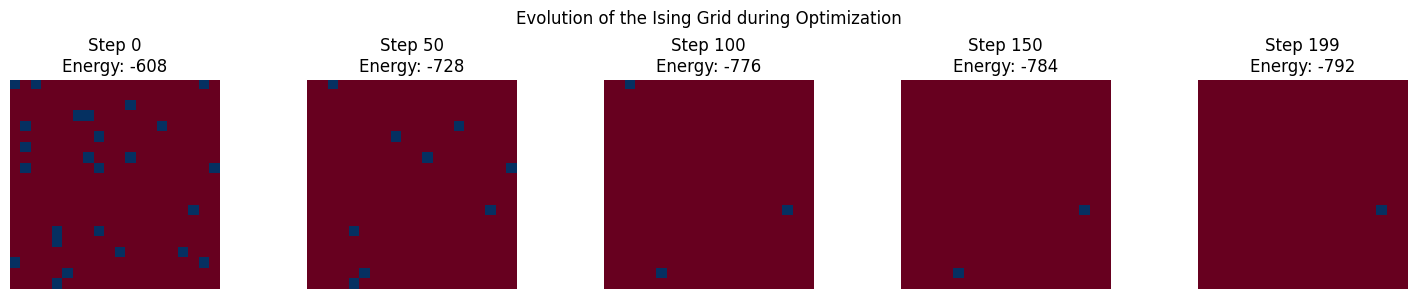

In [139]:
num_snaps = len(saved_grids)
fig, axes = plt.subplots(1, num_snaps, figsize=(15, 3))

for i, (step, grid) in enumerate(saved_grids):
    axes[i].imshow(grid, cmap='RdBu', vmin=-1, vmax=1)

    # Calculate energy for title
    en = compute_energy(grid)
    axes[i].set_title(f"Step {step}\nEnergy: {en:.0f}")
    axes[i].axis('off')

plt.suptitle("Evolution of the Ising Grid during Optimization")
plt.tight_layout()
plt.show()